### Model - A

In [1]:
# package libraries
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Dropout,Convolution2D,MaxPooling2D,Flatten,BatchNormalization,Activation,Conv2D
from keras.callbacks import EarlyStopping,ModelCheckpoint,LearningRateScheduler,TensorBoard,ReduceLROnPlateau
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image

import os
from os import listdir
from os.path import isfile, join 
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import random
from collections import Counter
from glob import iglob
from mpl_toolkits.axes_grid1 import ImageGrid
import cv2
import os, random
import matplotlib.pyplot as plt
import numpy as np
import pickle

import itertools
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)

Using TensorFlow backend.


### Model Setting

In [2]:
IMAGE_SIZE = (256,256)
INPUT_SHAPE = (256,256,3)

BATCH_SIZE = 12
EPOCHS = 20
STEP_PER_EPOCHS = 50

### Read Image Dataset

In [3]:
base_dir = 'dataset_v1'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
predict_dir = os.path.join(base_dir, 'predict')

### Creating objects for image augmentations

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=90,
                                   vertical_flip=True,
                                   horizontal_flip = True)
 
test_datagen = ImageDataGenerator(rescale = 1./255)
 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        directory=test_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 1588 images belonging to 4 classes.
Found 317 images belonging to 4 classes.


### Data Sample Plot

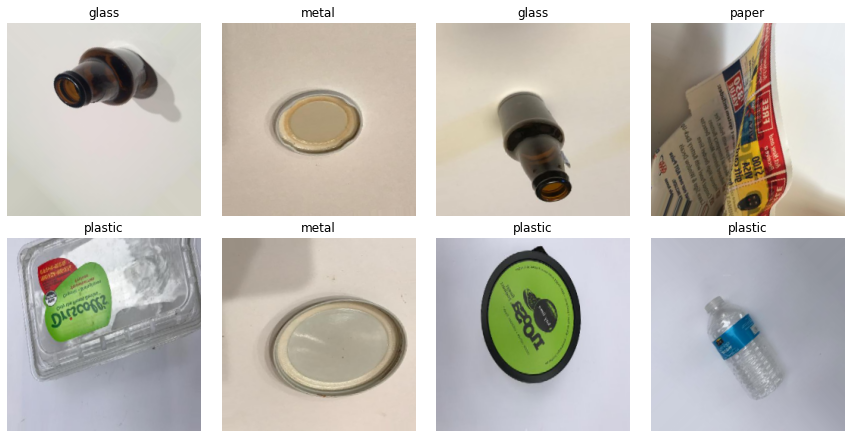

In [5]:
def plot(image_list,nrows,ncols,label_list=None,show_labels=False,savename=None,figsize=(10,10),showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
        if show_labels:
            ax.set_title(class_mapping[y_int[i]])
    if savename != None:
        plt.savefig(savename,bbox_inches='tight')
        

def percentage_value(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

def plot_dataset(path, title):
    classes = []
    for filename in iglob(os.path.join(path, "**","*.jpg")):
        classes.append(os.path.split(os.path.split(filename)[0])[-1])

    classes_cnt = Counter(classes)
    values = list(classes_cnt.values())
    labels = list(classes_cnt.keys())
     
    plt.figure(figsize=(10,10))
    plt.pie(values, labels=labels, autopct=lambda pct: percentage_value(pct, values), 
            shadow=True, startangle=140)

    plt.title(title)    
    plt.show()
    

x,y = next(train_generator) 
y_int = np.argmax(y,axis=-1)

class_mapping = {v:k for k,v in train_generator.class_indices.items()}

plot(x,2,4,label_list=y_int,show_labels=True,figsize=(15,10))

### Load ResNet50 with ImageNet weights

In [6]:
base_model = ResNet50(include_top=False, 
                      weights='imagenet',
                      input_shape=INPUT_SHAPE)

C:\Users\kaush\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [7]:
x = base_model.output

In [8]:
# Adding a Global Average Pooling layer
x = GlobalAveragePooling2D()(x)

x = BatchNormalization()(x) 

x = Dense(1024, activation='relu')(x)

In [9]:
# give the probability
predictions = Dense(4, activation='softmax')(x)
 
# Model to be trained
model = Model(inputs=base_model.input, outputs=predictions) 

In [10]:
# Compiling the model
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9, decay=0.0001), 
              loss='categorical_crossentropy', 
              metrics = ['accuracy'])

### Fit Model

In [11]:
STEP_PER_EPOCHS = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = test_generator.n//test_generator.batch_size

model_history = model.fit_generator(train_generator,
                    steps_per_epoch = STEP_PER_EPOCHS, epochs=EPOCHS,
                    validation_data=test_generator,
                    validation_steps=STEP_SIZE_VALID,
                    callbacks=[EarlyStopping(monitor='loss',patience=3,verbose=1)])

Epoch 1/20
132/132 [==============================] - 1039s 8s/step - loss: 1.0381 - accuracy: 0.5647 - val_loss: 1.4193 - val_accuracy: 0.1955
Epoch 2/20
132/132 [==============================] - 971s 7s/step - loss: 0.5800 - accuracy: 0.7868 - val_loss: 2.1647 - val_accuracy: 0.2623
Epoch 3/20
132/132 [==============================] - 994s 8s/step - loss: 0.4763 - accuracy: 0.8223 - val_loss: 2.9169 - val_accuracy: 0.2033
Epoch 4/20
132/132 [==============================] - 994s 8s/step - loss: 0.4256 - accuracy: 0.8452 - val_loss: 2.0701 - val_accuracy: 0.2361
Epoch 5/20
132/132 [==============================] - 970s 7s/step - loss: 0.3659 - accuracy: 0.8629 - val_loss: 2.6152 - val_accuracy: 0.3443
Epoch 6/20
132/132 [==============================] - 971s 7s/step - loss: 0.3238 - accuracy: 0.8852 - val_loss: 2.4650 - val_accuracy: 0.4197
Epoch 7/20
132/132 [==============================] - 1055s 8s/step - loss: 0.3155 - accuracy: 0.8934 - val_loss: 0.4462 - val_accuracy: 0.69

In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 2048)         0           activation_49[0][0]              
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 2048)         8192        global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         2098176     batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 4)            4100        dense_1[0][0]                    
Total params: 25,698,180
Trainable params: 25,640,964
Non-trainable params: 57,216
__________________________________________________________________________________________________


In [13]:
train_generator.class_indices

{'glass': 0, 'metal': 1, 'paper': 2, 'plastic': 3}

### Evaluate Test Dataset

In [14]:
train_result = model.evaluate(train_generator) 
test_result = model.evaluate(test_generator) 

print('Model Training Data Loss %.2f and,'
      'Accuracy of %.2f%% Training Dataset.' % (train_result[0], train_result[1]*100)) 

print('Model Test Loss %.2f and,'
      'Accuracy of %.2f%% Test Dataset.' % (test_result[0], test_result[1]*100)) 

27/27 [==============================] - 58s 2s/step
Model Loss 0.17 and,Accuracy of 96.35% Training Dataset.
Model Loss 0.55 and,Accuracy of 92.11% Test Dataset.


### Extract Features and Label From ResNet50 Model 

In [15]:
data_gen = ImageDataGenerator(rescale=1./255)
sample_count = 1588

def extract_features():
    features = np.zeros(shape=(sample_count,4))
    labels = np.zeros(shape=(sample_count,4))
    # Preprocess data
    generator = data_gen.flow_from_directory(train_dir,
                                            target_size=IMAGE_SIZE,
                                            batch_size = BATCH_SIZE,
                                            class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = model.predict(inputs_batch)
        features[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features()

Found 1588 images belonging to 4 classes.


### Train and Fit SVM Classifier

In [16]:
svm = SVC(kernel='rbf', C=1000, gamma=0.5)
 
svm.fit(train_features,np.argmax(train_labels,axis=1))

print('SVM Classifier Training Completed...')

SVM Classifier Training Completed...


### SVM Classifier Score

In [17]:
svm.score(train_features,np.argmax(train_labels,axis=1))

0.9861460957178841

### Model Accuracy and Loss plots

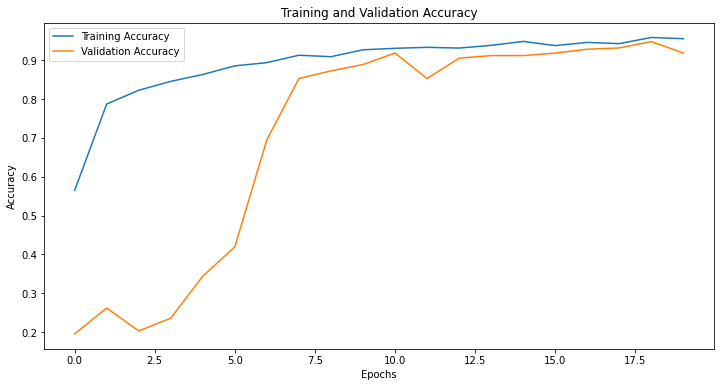

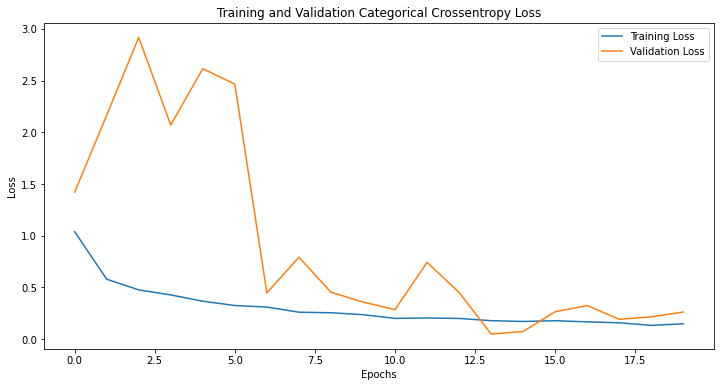

In [18]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)

def model_performance_plot(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
  
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],label='Training Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],label = 'Validation Accuracy')
    plt.legend()
  

    plt.figure()
    plt.xlabel('Epochs')
    plt.title('Training and Validation Categorical Crossentropy Loss')
    plt.plot(hist['epoch'], hist['loss'],label='Training Loss')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


model_performance_plot(model_history)

### Predict New Image

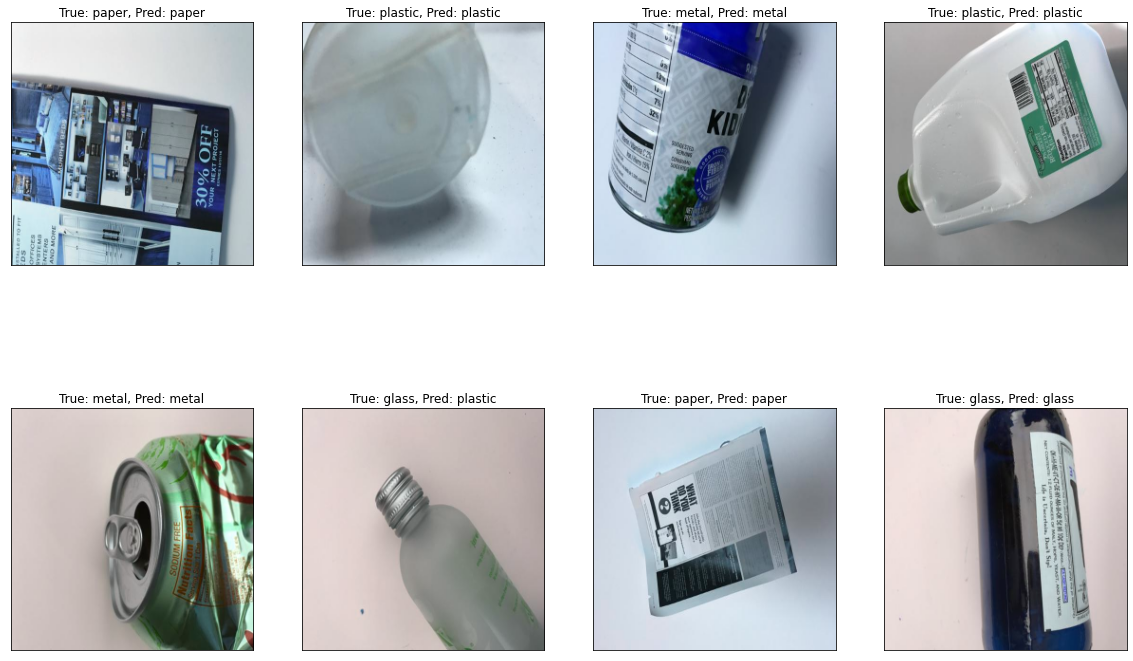

In [19]:
# Plot function 

def image_type(filename):
    
    if "glass" in filename:
        return 'glass'
    elif "metal" in filename:
        return 'metal'
    elif "paper" in filename:
        return 'paper'
    elif "plastic" in filename:
        return 'plastic'

def plot_predicted_label(nrows, ncols,onlyfiles):
    fig, axes = plt.subplots(nrows, ncols,figsize=(20, 13))
    
    rs = np.random.choice(len(onlyfiles),nrows*ncols,replace=False)
    
    for i, ax in zip(rs, axes.flat):
        img = cv2.imread(os.path.join(predict_dir, onlyfiles[i]))
        true_type = image_type(onlyfiles[i])
        img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1])) 
        img_tensor = image.img_to_array(img)
        img_tensor /= 255.
        
        # Extract features
        features = model.predict(img_tensor.reshape(1,IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
        
        prediction = svm.predict(features)
        index = int(prediction[0])
            
        title = 'True: %s, Pred: %s' % (true_type,class_mapping[index])
        ax.imshow(img, cmap='binary')
        ax.set_title(title)
         
        ax.set_xticks([])
        ax.set_yticks([])

num_rows = 2
num_cols = 4

# load image path to predict
onlyfiles = [f for f in listdir(predict_dir) if isfile(join(predict_dir, f))]
plot_predicted_label(num_rows, num_cols,onlyfiles);

### Save Model

In [20]:
model_filename = "model_resnet50.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)    

model.save('model_resnet50.h5')

model_filename = "svm_resnet50.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(svm, file)